In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os, time
import fitsio
import healpy as hp
from sklearn import cluster

--------
## Create mock data and initial grouping

In [71]:
# Create mock data
np.random.seed(2)
ra, dec = np.random.normal(0, 20, size=(2, int(1e6)))
mask = ra**2 + dec**2 < 400
ra = ra[mask]
dec = dec[mask]
print(len(ra))

# Translate all objects RA in to avoid RA=0
ra += 180.

394042


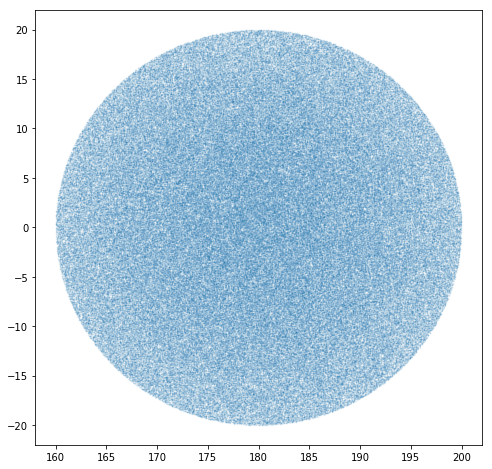

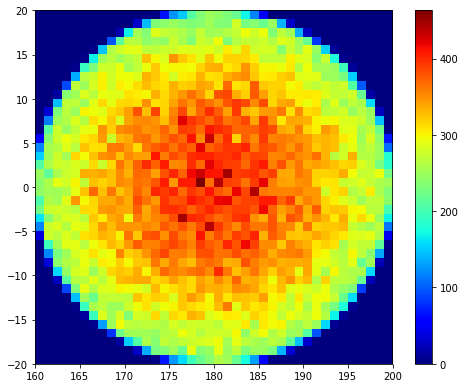

In [72]:
plt.figure(figsize=(8, 8))
plt.plot(ra, dec, '.', markersize=1, alpha=0.1)
plt.show()

plt.figure(figsize=(8, 6.5))
plt.hist2d(ra, dec, bins=40)
plt.colorbar()
plt.show()

6055 occupied heapix pixels
394042 objects


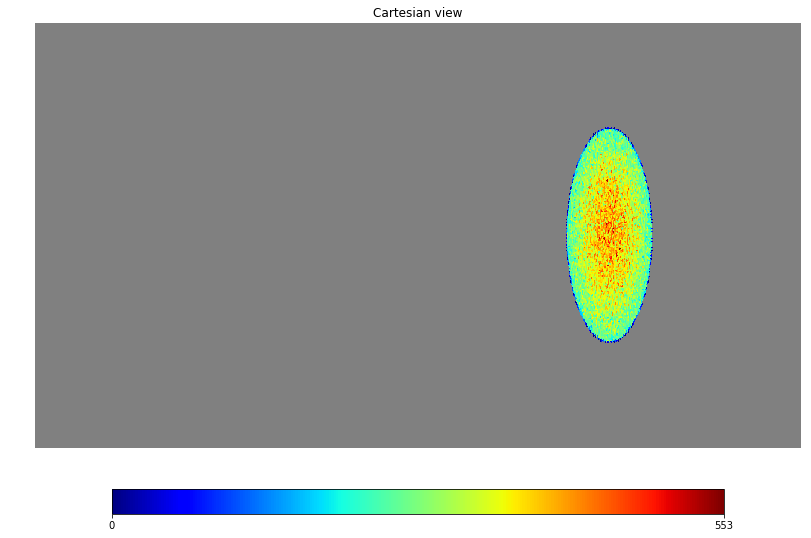

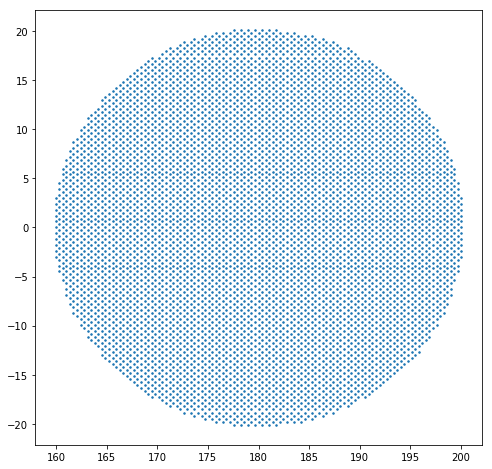

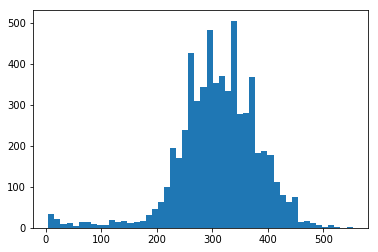

In [75]:
NSIDE = 2**7
npix = hp.nside2npix(NSIDE)
# hp.pixelfunc.ang2pix
hp_ra_all, hp_dec_all = hp.pixelfunc.pix2ang(NSIDE, np.arange(npix), lonlat=True)

pix = hp.pixelfunc.ang2pix(NSIDE, ra, dec, lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
density_all = np.zeros(npix)
density_all[pix_unique] = pix_count
# Convert to number density (per sq. deg.)
c = 1/(41253/npix)
density_all = density_all*c
occupied = density_all!=0
density = density_all[occupied]
hp_ra = hp_ra_all[occupied]
hp_dec = hp_dec_all[occupied]

print(np.sum(occupied), 'occupied heapix pixels')
print(int(np.sum(density_all[occupied])/c), 'objects')

density_all_masked = hp.ma(density_all)
density_all_masked.mask = ~occupied
plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(20, 8))
hp.cartview(density_all_masked, min=0, rot=(-90, 0, 0), fig=1, latra=(-40, 40), aspect=2.5, xsize=2000)
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(hp_ra, hp_dec, '.', markersize=3)
# plt.axis([360, 0, -21, 36])
plt.show()

plt.hist(density, 50)
plt.show()

__K-means clustering__

In [89]:
weighted_kmeans = False

if weighted_kmeans:
    # Apply weights by adding more of the same pixels to the array
    hp_ra_w = np.copy(hp_ra)
    hp_dec_w = np.copy(hp_dec)
    for i in range(1, 20):
        mask = np.round(density/50.)==i
        for j in range(i-1): # i-1 because there is already one copy
            hp_ra_w = np.concatenate([hp_ra_w, hp_ra[mask]])
            hp_dec_w = np.concatenate([hp_dec_w, hp_dec[mask]])
    print(len(hp_ra))
    print(len(hp_ra_w))
    coords = np.concatenate([[hp_ra_w], [hp_dec_w]])
    coords = coords.T
else:
    coords = np.concatenate([[hp_ra], [hp_dec]])
    coords = coords.T

In [90]:
n_clusters = 100

kmeans = cluster.KMeans(n_clusters=n_clusters, n_init=10)
t0 = time.time()
kmeans.fit(coords)
elapsed_time = time.time() - t0
print('time %.2fs'%(elapsed_time))

if weighted_kmeans:
    labels = kmeans.labels_[:len(hp_ra)]
else:
    labels = kmeans.labels_

time 2.56s


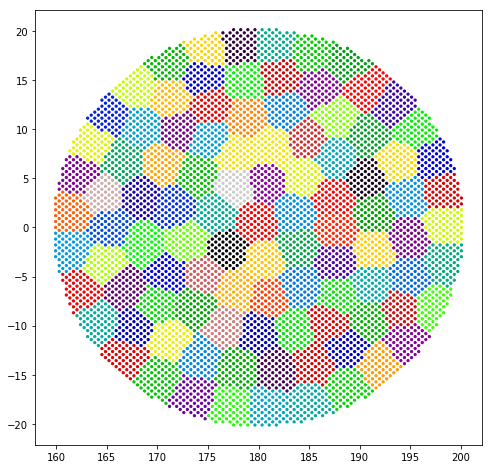

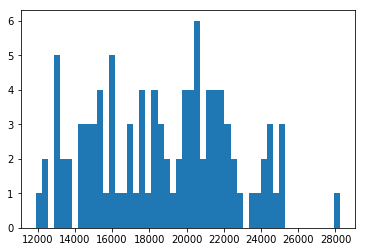

In [104]:
plt.figure(figsize=(8, 8))
plt.scatter(hp_ra, hp_dec, c=labels,
            cmap=plt.cm.spectral, s=5)
# plt.axis([360, 0, -21, 36])
plt.show()

weighted_counts = np.zeros(n_clusters)
for idx_grp in range(n_clusters):
    members = np.where(labels==idx_grp)[0]
    weighted_counts[idx_grp] = np.sum(density[members])
plt.hist(weighted_counts, 50)
plt.show()

__Save results to file__

In [92]:
t = Table()
t['ra'] = hp_ra
t['dec'] = hp_dec
t['count'] = density/c
t['density'] = density
t['label'] = labels

t.write('/Users/roz18/git/desi-photoz/test/clustering_demo_results.txt', format='ascii.commented_header')